# ***DS5220 Project***
---

### ***Import Data***

        Content
        1. Data Import
        2. Target Setting - Height/Age(v440), Weight/Age(hw8_1), Weight/Height(hw11_1)
        3. Data Cleaning: Null value, Replace values
        4. Data One-Hot Encoding


In [ ]:
### Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Drive Mount
from google.colab import drive
drive.mount("/content/drive")

# sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# torch
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Sequential, Module
from matplotlib import pyplot as plt
from scipy.stats import norm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Import Child Recode
import pandas as pd
Children_location = "/content/drive/MyDrive/NEU_Group project/DS5220_Project/dataset/Children Recode/ETKR71FL.DTA"
children_df = pd.read_stata(Children_location, convert_categoricals=False)
# Target
weight_age_sd = 'hw8'
height_age_sd = 'hw5'
weight_height_sd = 'hw11'
#new WHO values
weight_age_sd_new = 'hw71'
height_age_sd_new = 'hw70'
weight_height_sd_new = 'hw72'
# create stunting column
children_df['stunting'] = children_df[height_age_sd_new] < -100
# create wasting column
children_df['wasting'] = children_df[weight_height_sd_new] < -100
# create underweight column
children_df['underweight'] = children_df[weight_age_sd_new] < -100
#Divide by 10 to remove implied decimal place
children_df['hw3'] = children_df['hw3'] / 10
children_df['hw2'] = children_df['hw2'] / 10
children_df.head()
# Implement Target
children_df['target'] = (children_df['hw70'] < -100) & (children_df['hw71'] < -100) & (children_df['hw72'] < -100)
children_df = pd.DataFrame(children_df)
children_df['target'] = children_df['target'].astype(int)
children_df.rename(columns={"caseid":"case_id"}, inplace=True)
### children data
children_df = pd.DataFrame({
    "case_id":children_df["case_id"],
    "Target":children_df["target"]
})
children_df.head()
print("Target num: ", children_df[children_df["Target"]==True].count())

Target num:  case_id    1763
Target     1763
dtype: int64


<ipython-input-39-07afdc9dbe0f>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  children_df['stunting'] = children_df[height_age_sd_new] < -100
<ipython-input-39-07afdc9dbe0f>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  children_df['wasting'] = children_df[weight_height_sd_new] < -100
<ipython-input-39-07afdc9dbe0f>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [ ]:
 ### data eda
# count
print("Count:",children_df.shape)
children_df.head()

Count: (10641, 2)


,case_id,Target
0,1 17 2,1
1,1 17 2,0
2,1 17 2,0
3,1 18 2,0
4,1 25 2,0


In [ ]:
### Import individual
Individual_location = "/content/drive/MyDrive/NEU_Group project/DS5220_Project/dataset/Individual Recode/ETIR71FL.DTA"
individual_df = pd.read_stata(Individual_location, convert_categoricals=False)
individual_df = pd.DataFrame(individual_df)
individual_df.head()
# Feature Extratction
individual_df = individual_df[["caseid","v012","v013","v020","v025","v042","v044","v046","v101","v106",
                               "v119","v121","v130","v133","v151","v169a","v171a","v191a","v203","v218"]]
# Column Rename
individual_df = pd.DataFrame({
    'case_id': individual_df['caseid'],
    'age': individual_df['v012'],
    'Age in 5-year groups': individual_df['v013'],
    'Rular/City': individual_df['v025'],
    'Ever-married sample': individual_df['v020'] ,
    'Household selected for hemoglobin': individual_df['v042'],
    'Selected for Domestic Violence module': individual_df['v044'],
    'Translator used': individual_df['v046'],
    'Region': individual_df['v101'],
    'Highest educational level': individual_df['v106'],
    'Household has: electricity': individual_df['v119'],
    'Household has: television': individual_df['v121'],
    'Religion': individual_df['v130'],
    'Education in single years': individual_df['v133'],
    'Sex of household head': individual_df['v151'],
    'Owns a mobile telephone': individual_df['v169a'],
    'Use of internet': individual_df['v171a'],
    'Wealth index factor score for urban/rural': individual_df['v191a'],
    'Daughters at home': individual_df['v203'],
    'Number of living children': individual_df['v218'],
})
individual_df.head()

### Data Join(Individual & Children Recode)
df = pd.merge(individual_df, children_df, how="inner", on=("case_id"))
df.info()
# Data Split X, y
y = df[["Target"]]
X = df.drop(["Target"], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10641 entries, 0 to 10640
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   case_id                                    10641 non-null  object
 1   age                                        10641 non-null  int8  
 2   Age in 5-year groups                       10641 non-null  int8  
 3   Rular/City                                 10641 non-null  int8  
 4   Ever-married sample                        10641 non-null  int8  
 5   Household selected for hemoglobin          10641 non-null  int8  
 6   Selected for Domestic Violence module      10641 non-null  int8  
 7   Translator used                            10641 non-null  int8  
 8   Region                                     10641 non-null  int8  
 9   Highest educational level                  10641 non-null  int8  
 10  Household has: electricity        

In [ ]:
### Data EDA
# One-hot encoding // v026, v044, v101, v119(7->0), v120(7->0), v130, v171a
temp_data = X
y.replace({"True":1, "False":0}, inplace=True)
X.replace({"Household has: electricity":7}, 0, inplace=True)
X.replace({"Household has: television":7}, 0, inplace=True)
X["Rular/City"].replace({1:"Urban", 2:"Rural"}, inplace=True)
X["Region"].replace({1:"Tigray", 2:"Afar", 3:"Amhara",4:"Oromia",5:"Somali",6:"Benishangul",
                       7:"SNNPR",8:"Gambela",9:"Harari",10:"Addis Adaba",11:"Dire Dawa"}, inplace=True)
X["Religion"].replace({1:"Orthodox",2:"Catholic",3:"Protestant",4:"Muslin",5:"Traditional",96:"Other"}, inplace=True)
X["Use of internet"].replace({0:"Never",1:"Yes, last 12 months",2:"Yes, before last 12 months",3:"Yes, can't establish when"}, inplace=True)
temp_X = X[["Rular/City","Region","Religion","Use of internet"]]
X_dum = pd.get_dummies(temp_X)
X.drop(["Rular/City","Region","Religion","Use of internet"], axis=1, inplace=True)
X.drop(["case_id"], axis=1, inplace=True)
X = pd.concat([X, X_dum], axis=1)
# Resample
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=22)
X, y = sm.fit_resample(X, y)
X.head()

<ipython-input-41-e9415ea278c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace({"True":1, "False":0}, inplace=True)


,age,Age in 5-year groups,Ever-married sample,Household selected for hemoglobin,Selected for Domestic Violence module,Translator used,Highest educational level,Household has: electricity,Household has: television,Education in single years,...,Region_Tigray,Religion_Catholic,Religion_Muslin,Religion_Orthodox,Religion_Other,Religion_Protestant,Religion_Traditional,Use of internet_Never,"Use of internet_Yes, before last 12 months","Use of internet_Yes, last 12 months"
0,38,5,0,1,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
1,38,5,0,1,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
2,38,5,0,1,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
3,42,6,0,1,0,0,1,0,0,3,...,False,False,True,False,False,False,False,True,False,False
4,46,7,0,1,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False


### ***RandomForest***

In [ ]:
### Modeling
### RandomForest
# from sklearn import model_selection
from sklearn import model_selection
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify = y, random_state = 22)
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')
# RF
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators=20, max_features=40, random_state=22)
classifier_RF.fit(X_train, y_train)
y_pred = classifier_RF.predict(X_test)

training data has 14204 observation with 37 features
test data has 3552 observation with 37 features


<ipython-input-25-4951b084af96>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier_RF.fit(X_train, y_train)


Precision Score:  0.886404833836858
Recall Score:  0.8260135135135135
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1776
           1       0.89      0.83      0.86      1776

    accuracy                           0.86      3552
   macro avg       0.86      0.86      0.86      3552
weighted avg       0.86      0.86      0.86      3552



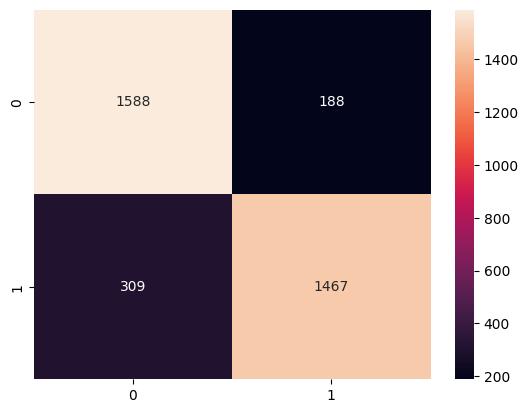

In [ ]:
### RF Confusion Matrix
"""
The reason that the score of precision and recall is so low,
beacause of the lack of absolute undernutrition data(True).
For our next step of improvements, we have to solve the lack of True data
"""
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

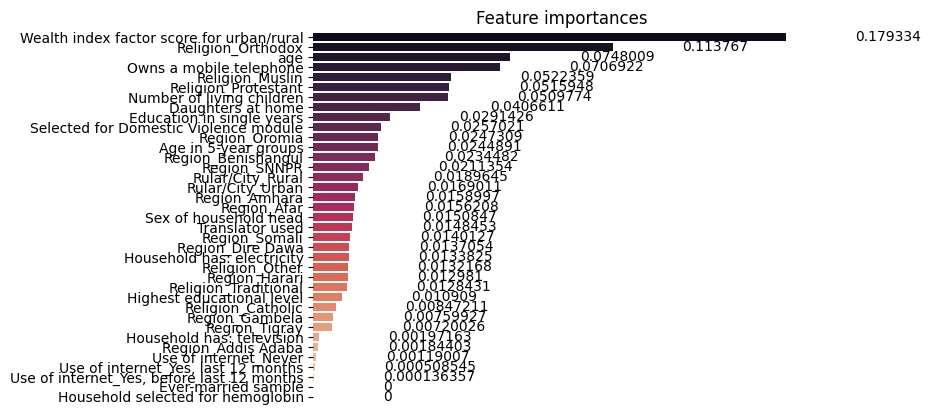

In [ ]:
### RF Feature Importance
# Organizing feature names and importances in a DataFrame
features_df = pd.DataFrame({'features': classifier_RF.feature_names_in_, 'importances': classifier_RF.feature_importances_ })
# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)
# Barplot of the result without borders and axis lines
Feature_importance = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
Feature_importance.set_title('Feature importances')
Feature_importance.set(xlabel=None)
Feature_importance.set(ylabel=None)
Feature_importance.set(xticks=[])
for value in Feature_importance.containers:
    Feature_importance.bar_label(value, padding=50)

### ***Naive Bayes***
---

In [ ]:
### Fitting
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision Score:  0.886404833836858
Recall Score:  0.8260135135135135
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1776
           1       0.89      0.83      0.86      1776

    accuracy                           0.86      3552
   macro avg       0.86      0.86      0.86      3552
weighted avg       0.86      0.86      0.86      3552



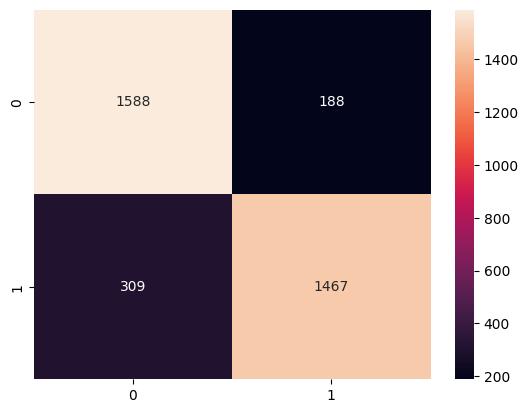

In [ ]:
### Naive Bayes Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

### ***SVM***
---

In [ ]:
### SVM
# Standardization (For SVM and MLP)
from sklearn.preprocessing import StandardScaler
X_scaler = X
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
column =['age', 'Age in 5-year groups', 'Ever-married sample',
       'Household selected for hemoglobin',
       'Selected for Domestic Violence module', 'Translator used',
       'Highest educational level', 'Household has: electricity',
       'Household has: television', 'Education in single years',
       'Sex of household head', 'Owns a mobile telephone',
       'Wealth index factor score for urban/rural', 'Daughters at home',
       'Number of living children', 'Rular/City_Rural', 'Rular/City_Urban',
       'Region_Addis Adaba', 'Region_Afar', 'Region_Amhara',
       'Region_Benishangul', 'Region_Dire Dawa', 'Region_Gambela',
       'Region_Harari', 'Region_Oromia', 'Region_SNNPR', 'Region_Somali',
       'Region_Tigray', 'Religion_Catholic', 'Religion_Muslin',
       'Religion_Orthodox', 'Religion_Other', 'Religion_Protestant',
       'Religion_Traditional', 'Use of internet_Never',
       'Use of internet_Yes, before last 12 months',
       'Use of internet_Yes, last 12 months']
X = pd.DataFrame(X_scaler, columns=column)
X.head()

,age,Age in 5-year groups,Ever-married sample,Household selected for hemoglobin,Selected for Domestic Violence module,Translator used,Highest educational level,Household has: electricity,Household has: television,Education in single years,...,Region_Tigray,Religion_Catholic,Religion_Muslin,Religion_Orthodox,Religion_Other,Religion_Protestant,Religion_Traditional,Use of internet_Never,"Use of internet_Yes, before last 12 months","Use of internet_Yes, last 12 months"
0,1.453822,1.284625,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
1,1.453822,1.284625,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
2,1.453822,1.284625,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
3,2.111207,2.083064,0.0,0.0,-0.728142,-0.683074,0.938170,-0.419397,-0.315237,0.318825,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
4,2.768593,2.881503,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425


In [ ]:
### SVM
# Data Split
from sklearn import svm
from sklearn.svm import SVC
from sklearn import model_selection
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify = y, random_state = 22)
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 14204 observation with 37 features
test data has 3552 observation with 37 features


In [ ]:
# Predict
cf_svm = svm.SVC(kernel="poly", C=0.1).fit(X_train, y_train)
cf_svm.fit(X_train, y_train)
y_pred = cf_svm.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision Score:  0.9434546862896979
Recall Score:  0.6858108108108109
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      1776
           1       0.94      0.69      0.79      1776

    accuracy                           0.82      3552
   macro avg       0.85      0.82      0.82      3552
weighted avg       0.85      0.82      0.82      3552



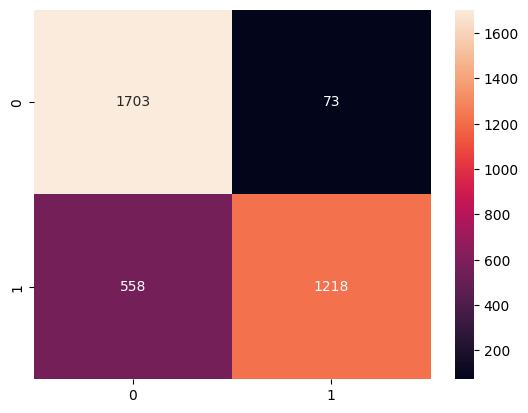

In [ ]:
### SVM Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

### ***MLP***
---

training data has 14204 observation with 37 features
test data has 3552 observation with 37 features
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 37)                0         
                                                                 
 dense (Dense)               (None, 50)                1900      
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
444/444 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/30
444/444 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/30
444/444 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/30
444/444 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/30
444/444 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/30
444/444 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/30
444/444 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/30
444/444 [============================

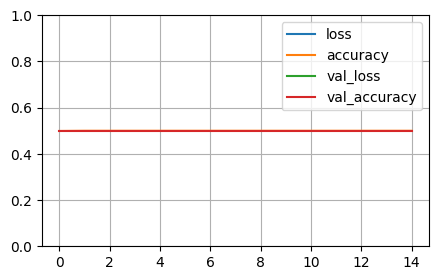

In [ ]:
### MLP(Multi Layer Perceptron)
# Train Test Split
from tensorflow import keras
from sklearn import model_selection
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify = y, random_state = 22)
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')
# Sequential Layers
mlp_clf = keras.models.Sequential([
                                   keras.layers.Flatten(input_shape=(37,)),
                                   keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal"),
                                   keras.layers.Dense(25, activation="elu", kernel_initializer="he_normal"),
                                   keras.layers.Dense(1, activation="sigmoid")
])
# MLP Callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("MLP", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
# Model Summary
mlp_clf.summary()
# Model Complie
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mlp_clf.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Model Fitting
mlp_clf.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[checkpoint_cb, early_stopping_cb])
mlp_history = mlp_clf
# Accuracy measurement
mlp_history = mlp_history.history
# mlp_clf Loss, Accuracy check
pd.DataFrame(mlp_history.history).plot(figsize=(5,3))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
### MLP Confusion Matrix
results = mlp_clf.evaluate(X_test, y_test, batch_size=128)
print("test loss, test accuracy:", results)

28/28 [==============================] - 0s 3ms/step - loss: 0.3416 - accuracy: 0.8454
test loss, test accuracy: [0.341560959815979, 0.8454391956329346]


111/111 [==============================] - 0s 1ms/step
Precision Score:  0.9372772630078403
Recall Score:  0.7404279279279279
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1776
           1       0.94      0.74      0.83      1776

    accuracy                           0.85      3552
   macro avg       0.86      0.85      0.84      3552
weighted avg       0.86      0.85      0.84      3552



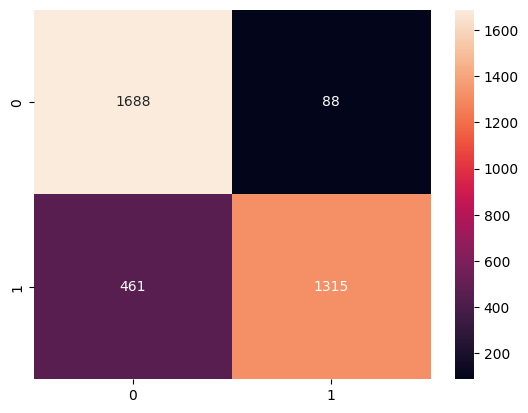

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
y_pred = []
predictions = mlp_clf.predict(X_test)
for i in predictions:
    if i >= 0.5:
        result = 1
        y_pred.append(result)
    else:
        result = 0
        y_pred.append(result)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

### ***ResNet***
---

In [ ]:
### scaling
from sklearn.preprocessing import StandardScaler
# columns
numerical_columns=["age","Age in 5-year groups"]
numerical_df=X[numerical_columns]
categorical_df=X.drop(columns=numerical_columns)

# scaling
scaler=StandardScaler()
numerical_df_scaled = pd.DataFrame(scaler.fit_transform(numerical_df), columns=numerical_columns, index=numerical_df.index)

# concat
X=pd.concat([numerical_df_scaled,categorical_df],axis=1)
X.head()

,age,Age in 5-year groups,Ever-married sample,Household selected for hemoglobin,Selected for Domestic Violence module,Translator used,Highest educational level,Household has: electricity,Household has: television,Education in single years,...,Region_Tigray,Religion_Catholic,Religion_Muslin,Religion_Orthodox,Religion_Other,Religion_Protestant,Religion_Traditional,Use of internet_Never,"Use of internet_Yes, before last 12 months","Use of internet_Yes, last 12 months"
0,1.453822,1.284625,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
1,1.453822,1.284625,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
2,1.453822,1.284625,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
3,2.111207,2.083064,0.0,0.0,-0.728142,-0.683074,0.938170,-0.419397,-0.315237,0.318825,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425
4,2.768593,2.881503,0.0,0.0,-0.728142,-0.683074,-0.530414,-0.419397,-0.315237,-0.552509,...,-0.264988,-0.063808,1.121298,-0.528616,-0.067275,-0.359585,-0.079314,0.158287,-0.043801,-0.125425


In [ ]:
### dataloader
# data split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# to tensor
train_data=torch.tensor(X_train.values,dtype=torch.float32)
train_labels=torch.tensor(y_train.values,dtype=torch.long)
test_data=torch.tensor(X_test.values,dtype=torch.float32)
test_labels=torch.tensor(y_test.values,dtype=torch.long)

# data loader
class CustomDataset(Dataset):
    def __init__(self,data,labels):
        self.data=data
        self.labels=labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        sample_data=self.data[idx]
        sample_label=self.labels[idx]
        return sample_data,sample_label

    # trainloader
trainloader=CustomDataset(train_data,train_labels)
trainloader=DataLoader(dataset=trainloader,batch_size=32,shuffle=True)

    # testloader
custom_test=CustomDataset(test_data,test_labels)
testloader=DataLoader(dataset=custom_test,batch_size=32,shuffle=True)

# size check
train_sample, label_sample=train_data,train_labels
input_size=train_sample.shape[1]
output_size=len(torch.unique(label_sample))
print("Input Size:",input_size)
print("Output Size:",output_size)

Input Size: 37
Output Size: 2


In [ ]:
### model build
# resnet
class ResidualSequence(nn.Module):
    def __init__(self,*layers):
        super(ResidualSequence,self).__init__()
        self.layers=nn.Sequential(*layers)

    def forward(self, x):
        side_result=self.layers(x)
        return x+side_result

# main
class ClassificationNetwork(nn.Module):
    def __init__(self, input_size=37, hidden_dims=64, class_size=1):
        super(ClassificationNetwork, self).__init__()

        self.input_size=37
        self.hidden_dims=64
        self.class_size=1

        # Main network with ResidualSequence blocks
        self.front_gate = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_dims),
            nn.ReLU(),

            ResidualSequence(
                nn.BatchNorm1d(self.hidden_dims),
                nn.Linear(self.hidden_dims,64),
                nn.ReLU(),
                nn.Linear(64,self.hidden_dims)
            ),

            ResidualSequence(
                nn.BatchNorm1d(self.hidden_dims),
                nn.Linear(self.hidden_dims,128),
                nn.ReLU(),
                nn.Linear(128,self.hidden_dims)
            ),

            ResidualSequence(
                nn.BatchNorm1d(self.hidden_dims),
                nn.Linear(self.hidden_dims,64),
                nn.ReLU(),
                nn.Linear(64,self.hidden_dims)
            ),

            nn.BatchNorm1d(self.hidden_dims),
            nn.ReLU(),
            nn.Linear(self.hidden_dims, self.class_size),
            nn.Sigmoid()
            )

    def init_wegihts(self,m):
        if isinstance(m,nn.Linear):
            init.kaiming_normal_(m.weight,mode="fanout",nonlinearity="relu")
            if m.bias is not None:
                init.constant_(m.bias,0)

        # forward
    def forward(self, x):
        x=self.front_gate(x)
        return x

In [ ]:
### build
device = "cuda" if torch.cuda.is_available() else "cpu"
model=ClassificationNetwork().to(device)
model.requires_grad_(True)

learning_rate=1e-4
batch_size=32
epochs=15
weight_decay=1e-4
loss_fn=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

print(model)

ClassificationNetwork(
  (front_gate): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): ResidualSequence(
      (layers): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=64, out_features=128, bias=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=64, bias=True)
      )
    )
    (3): ResidualSequence(
      (layers): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=64, out_features=256, bias=True)
        (2): ReLU()
        (3): Linear(in_features=256, out_features=64, bias=True)
      )
    )
    (4): ResidualSequence(
      (layers): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=64, out_features=128, bias=True)
        (2): ReLU()
        (3): Lin

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, print_log=True):
    size = len(dataloader.dataset)
    num_batches=len(dataloader)
    correct = 0
    training_acc = 0
    training_loss = 0
    total_loss=0

    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device).float())
        correct_preds=(pred>=0.5).float()
        correct += (correct_preds==y.to(device)).type(torch.float).sum().item()
        total_loss+=loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (print_log==True) and (batch % 100 == 0):
            current=batch*len(X)
            print(f"""Training loop: loss: {loss:>7f}  [{current:>5d}/{size:>5d}]""")

    training_loss=total_loss/num_batches
    training_acc = 100 * (correct/size)

    if print_log:
      print(f"""Training Accuracy: {training_acc:>0.1f}%""")

    return training_acc, training_loss

def test_loop(dataloader, model, loss_fn, print_log=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader) # batch 개수
    test_loss, correct = 0, 0

    model.eval()

    with torch.no_grad(): # optimizer.zero_grad() 와는 다른 개념이다. 애초에 grad 역전파 계산이 필요 없다
        for X, y in dataloader:
            X,y=X.to(device),y.to(device).float()
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item() # loss_fn 안에 이미 손실함수 식과 평균 작업이 들어가 있기에 현재 test_loss 누적합은 배치 집합 수의 Loss 누적합이다.
            correct_preds=(pred>=0.5).float()
            correct += (correct_preds == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    testing_acc = 100*(correct/size)

    if (print_log==True):
        print(f"Testing Accuracy: {testing_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return testing_acc, test_loss

Epoch 1
-------------------------------
Training loop: loss: 0.112188  [    0/14204]
Training loop: loss: 0.219884  [ 3200/14204]
Training loop: loss: 0.291477  [ 6400/14204]
Training loop: loss: 0.265061  [ 9600/14204]
Training loop: loss: 0.242432  [12800/14204]
Training Accuracy: 89.5%
Testing Accuracy: 84.7%, Avg loss: 0.391664 

Epoch 2
-------------------------------
Training loop: loss: 0.109423  [    0/14204]
Training loop: loss: 0.182260  [ 3200/14204]
Training loop: loss: 0.097344  [ 6400/14204]
Training loop: loss: 0.408214  [ 9600/14204]
Training loop: loss: 0.162484  [12800/14204]
Training Accuracy: 89.3%
Testing Accuracy: 84.6%, Avg loss: 0.392643 

Epoch 3
-------------------------------
Training loop: loss: 0.148445  [    0/14204]
Training loop: loss: 0.252286  [ 3200/14204]
Training loop: loss: 0.176346  [ 6400/14204]
Training loop: loss: 0.319859  [ 9600/14204]
Training loop: loss: 0.323802  [12800/14204]
Training Accuracy: 89.3%
Testing Accuracy: 85.2%, Avg loss: 0.3

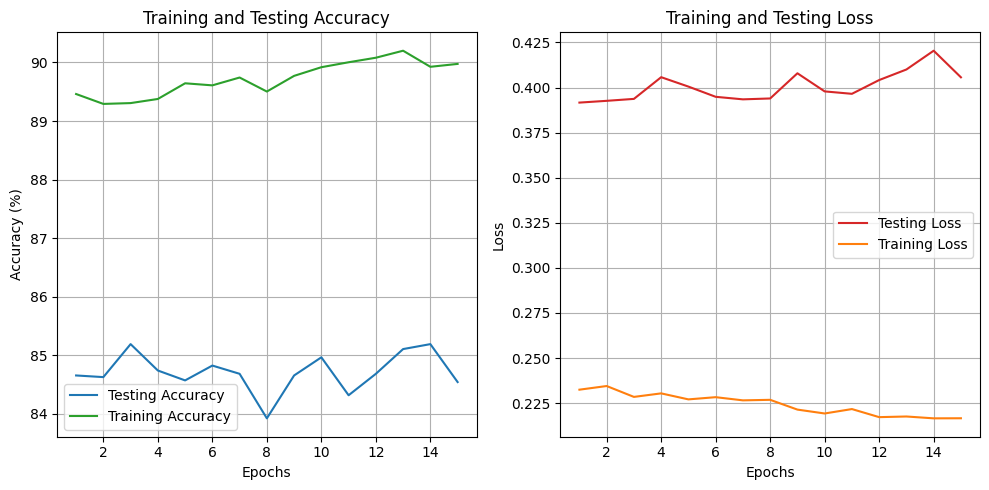

In [ ]:
num_epochs=[i+1 for i in range(epochs)]
training_accs = []
training_losses=[]
test_accs=[]
test_losses=[]

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_acc,training_loss=train_loop(trainloader, model, loss_fn, optimizer)
    testing_acc,test_loss=test_loop(testloader, model, loss_fn)
    training_losses.append(training_loss)
    training_accs.append(training_acc)
    test_losses.append(test_loss)
    test_accs.append(testing_acc)
print("Done!")

# plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

  # ax1
ax1.plot(num_epochs, test_accs, 'tab:blue', label='Testing Accuracy')
ax1.plot(num_epochs, training_accs, 'tab:green', label='Training Accuracy')
ax1.set_title('Training and Testing Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True)

  # ax2
ax2.plot(num_epochs, test_losses, 'tab:red', label='Testing Loss')
ax2.plot(num_epochs, training_losses, 'tab:orange', label='Training Loss')
ax2.set_title('Training and Testing Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()